In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/N/slate/qmnguyen/projects/future-sst-prediction-diffusion


In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Lambda
from tqdm.auto import tqdm

from sst import (
    ConditionalBackwardSampler,
    ForwardSampler,
    LinearBetaScheduler,
)
from sst.dataset import NOAA_OI_SST, Difference_NOAA_OI_SST
from sst.dataset.transforms import ScaleTemperature
from sst.layers import SinusoidalPositionEncoding
from sst.training_procedures import ConditionalOnPastSSTTrainingProcedure

# Future SST Difference Prediction using Fully Connected Networks with Conditional Diffusion

In this experiment,
I will try to implement the idea of Saharia et al. (2022) to predict future SST
conditioning on the past 4-day SST.
But instead of using UNet architecture, I will just use a normal fully-connected network.

## Dataset

Similar to that of [sst_unconditional_diffusion.py](./sst_unconditional_diffusion.py):

In [3]:
temp_diff_scaler = ScaleTemperature(min_temp=0, max_temp=1)
transform_fn = Compose([
    # temp_diff_scaler,
    # Lambda(lambda s: (2*s[0] - 1, 2*s[1] - 1))
])
train_ds = NOAA_OI_SST(train=True)
train_ds = Difference_NOAA_OI_SST(
    train_ds, transform=transform_fn)

We will want to split the data into training and validation data using 20% split:
80% for training and 20% for validation.

In [4]:
train_size = int(len(train_ds) * 0.8)
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
print(f'{train_size=} {len(train_ds)=}')
print(f'{val_size=} {len(val_ds)=}')

train_size=75129 len(train_ds)=75129
val_size=18783 len(val_ds)=18783


In addition, we will need test dataset for this experiment.

In [5]:
test_ds = NOAA_OI_SST(train=False)
test_diff_ds = Difference_NOAA_OI_SST(
    test_ds, transform=transform_fn)
print(f'{len(test_ds)=}')

len(test_ds)=2892


## Fully-Connected Network

In [6]:
class FutureSSTNoisePredictionModel(nn.Module):
    def __init__(self, nb_past_observations: int) -> None:
        super().__init__()

        self.flatten = nn.Flatten()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEncoding(24 * 24),
            nn.Linear(24*24, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )
        self.first = nn.Sequential(
            nn.Linear(24*24, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )

        self.past_observation_mlp = nn.Sequential(
            nn.Linear(24*24*nb_past_observations, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )

        self.hidden = nn.Sequential(
            # Encoder.
            nn.Linear(4096, 2048), nn.LayerNorm(2048), nn.SiLU(),
            # # Decoder.
            nn.Linear(2048, 24 * 24),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 24, 24))


    def forward(self, noisy_sst: torch.Tensor, past_sst: torch.Tensor, time_steps: torch.Tensor):
        # Process noisy SST.
        x1 = self.flatten(noisy_sst)
        x1 = self.first(x1)
        x1 += self.time_mlp(time_steps)

        # Process past SST.
        x2 = self.flatten(past_sst)
        x2 = self.past_observation_mlp(x2)

        # Concatenate the noisy SST and past SST.
        x = torch.concat([x1, x2], dim=1)

        x = self.hidden(x)
        x = self.unflatten(x)
        return x

### Training

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


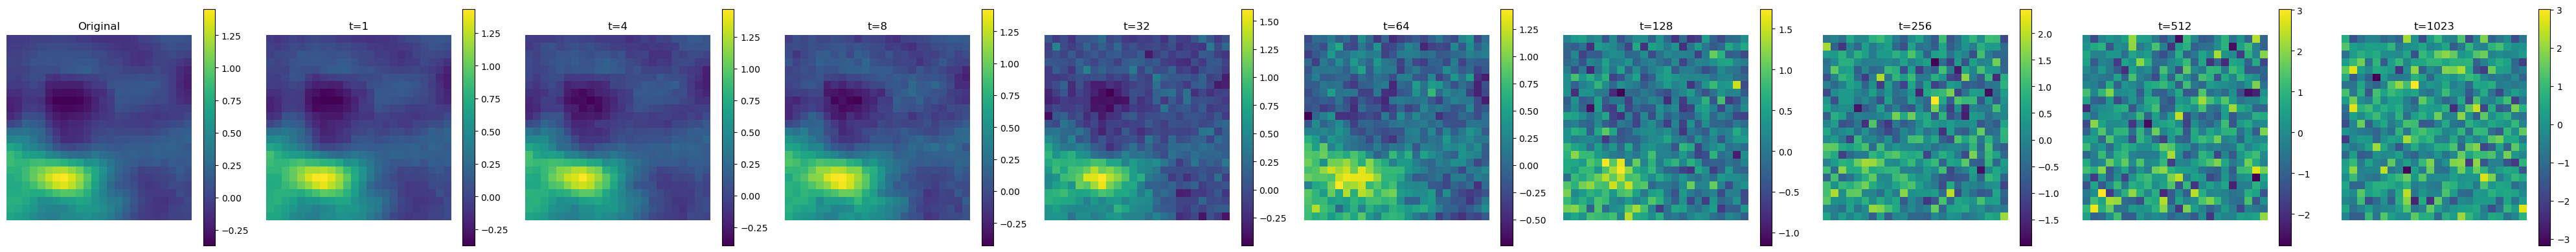

In [8]:
beta_scheduler = LinearBetaScheduler(1e-4, 0.02, 1024)
forward_sampler = ForwardSampler(beta_scheduler)

# I didn't verify whether the forward sampler is doing what we expect.
# So let's do it now.
time_steps = [1, 4, 8, 32, 64, 128, 256, 512, 1023]
fig, axes = plt.subplots(
    ncols=len(time_steps) + 1,
    figsize=(4 * len(time_steps) + 4, 4))
for ax, t in zip(axes[1:], time_steps):
    _, sst = train_ds[2555]
    sst = torch.tensor(sst)
    noisy_sst, _ = forward_sampler(sst, torch.tensor(t))
    cs = ax.imshow(noisy_sst[0])
    fig.colorbar(cs, ax=ax)
    ax.axis('off')
    ax.set_title(f'{t=}')

ax = axes[0]
cs = ax.imshow(sst[0])
fig.colorbar(cs, ax=ax)
ax.axis('off')
ax.set_title('Original')
fig.tight_layout()

It looks good!

Now, we will train the model.

In [9]:
model = FutureSSTNoisePredictionModel(3)
training_procedure = ConditionalOnPastSSTTrainingProcedure(model, forward_sampler, device)

train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_ds, batch_size=256, num_workers=4)

epochs = 1 if device == 'cpu' else 500
for epoch in range(epochs):
    train_loss = training_procedure.train(train_dataloader, epoch)
    val_loss = training_procedure.evaluate(val_dataloader)

    print(f'{train_loss=} {val_loss=}')

Skipped init weight for module m=Flatten(start_dim=1, end_dim=-1).
Skipped init weight for module m=SinusoidalPositionEncoding().
Skipped init weight for module m=LayerNorm((2048,), eps=1e-05, elementwise_affine=True).
Skipped init weight for module m=SiLU().
Skipped init weight for module m=Sequential(
  (0): SinusoidalPositionEncoding()
  (1): Linear(in_features=576, out_features=2048, bias=True)
  (2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (3): SiLU()
).
Skipped init weight for module m=LayerNorm((2048,), eps=1e-05, elementwise_affine=True).
Skipped init weight for module m=SiLU().
Skipped init weight for module m=Sequential(
  (0): Linear(in_features=576, out_features=2048, bias=True)
  (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (2): SiLU()
).
Skipped init weight for module m=LayerNorm((2048,), eps=1e-05, elementwise_affine=True).
Skipped init weight for module m=SiLU().
Skipped init weight for module m=Sequential(
  (0): Linear(in_features=172

Training epoch 0:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.16977439397553198 val_loss=0.07705458092528421


Training epoch 1:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.06807092973823045 val_loss=0.06232012672400152


Training epoch 2:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.05602622911536775 val_loss=0.05232428563003604


Training epoch 3:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.04737059773281724 val_loss=0.04473056971422724


Training epoch 4:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.04059850887655198 val_loss=0.03926583248618487


Training epoch 5:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.03612937253652787 val_loss=0.03585904136904188


Training epoch 6:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.03344288120540429 val_loss=0.03259467982963936


Training epoch 7:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.031303474971023544 val_loss=0.0307019872691583


Training epoch 8:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.03002443802574662 val_loss=0.030699092265520547


Training epoch 9:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.028852964472659184 val_loss=0.028887276864937833


Training epoch 10:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.027710151636884325 val_loss=0.027798154592715407


Training epoch 11:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.027269884373764604 val_loss=0.0273280554526561


Training epoch 12:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.026816020903437317 val_loss=0.02739831110512888


Training epoch 13:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.026019373534842818 val_loss=0.02579919885642625


Training epoch 14:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.025831887390793992 val_loss=0.025430128305546335


Training epoch 15:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.024897952494369883 val_loss=0.025253319282185386


Training epoch 16:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.024327363603475954 val_loss=0.02547883617414816


Training epoch 17:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02385549019819417 val_loss=0.024677546266969795


Training epoch 18:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.024103688183842467 val_loss=0.02399892785359879


Training epoch 19:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.023493476978623543 val_loss=0.02362391455854113


Training epoch 20:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02324316041151277 val_loss=0.02294650220790425


Training epoch 21:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022811505823161733 val_loss=0.02275351180720168


Training epoch 22:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022730208939688953 val_loss=0.023373938694193557


Training epoch 23:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022344396392605742 val_loss=0.022325366911654536


Training epoch 24:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022489362136543203 val_loss=0.022766184917575604


Training epoch 25:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022003783774720568 val_loss=0.022622576725946086


Training epoch 26:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02190660918448247 val_loss=0.021862484363688005


Training epoch 27:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021521437818146482 val_loss=0.02175365265056088


Training epoch 28:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021700765576441676 val_loss=0.021412905884554256


Training epoch 29:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021468567541566026 val_loss=0.022224990726524108


Training epoch 30:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020973943576191357 val_loss=0.021715772967483546


Training epoch 31:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021216146780976226 val_loss=0.021434032106520357


Training epoch 32:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02061640247575888 val_loss=0.02089802662816805


Training epoch 33:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020263177694334666 val_loss=0.020601663184729783


Training epoch 34:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02045342165558618 val_loss=0.02109739209550458


Training epoch 35:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020141600434776065 val_loss=0.020010929177137645


Training epoch 36:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02051684930033627 val_loss=0.02085641388957565


Training epoch 37:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020630176492719626 val_loss=0.021446963256174647


Training epoch 38:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02025497287866615 val_loss=0.020887863243351113


Training epoch 39:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020521890391044472 val_loss=0.020676748625732756


Training epoch 40:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020342226808599265 val_loss=0.020210373555184215


Training epoch 41:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020128593387297628 val_loss=0.020204166239882644


Training epoch 42:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019964037542263058 val_loss=0.020977100432925933


Training epoch 43:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019860309539172723 val_loss=0.019714116383142567


Training epoch 44:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020055687441458914 val_loss=0.020063493828717117


Training epoch 45:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01991743332433964 val_loss=0.020455384362690354


Training epoch 46:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020004518966817736 val_loss=0.0199154522521673


Training epoch 47:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019630902136365574 val_loss=0.02022905000863043


Training epoch 48:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019597126266025767 val_loss=0.020273846032953746


Training epoch 49:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019490176830820893 val_loss=0.01952087183206065


Training epoch 50:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0196010846308857 val_loss=0.020184280829051056


Training epoch 51:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0197601268308706 val_loss=0.01907337986788637


Training epoch 52:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019477843275281036 val_loss=0.019288480445440556


Training epoch 53:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019458529156106873 val_loss=0.019963854936429777


Training epoch 54:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01948153303277229 val_loss=0.019770736919363607


Training epoch 55:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019173277399445673 val_loss=0.019880454886604


Training epoch 56:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019310168925115244 val_loss=0.01938800294757695


Training epoch 57:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019078783507199108 val_loss=0.02004581136075226


Training epoch 58:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019289786613793398 val_loss=0.019461208237083378


Training epoch 59:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019207565012533647 val_loss=0.019186214783002396


Training epoch 60:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019072993439907322 val_loss=0.01957030888848208


Training epoch 61:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019098631172840084 val_loss=0.019528897567274602


Training epoch 62:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018983998364407798 val_loss=0.01944275647150101


Training epoch 63:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019077458136974753 val_loss=0.019337289425468928


Training epoch 64:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019062322776663265 val_loss=0.01935331366100424


Training epoch 65:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01913796514145979 val_loss=0.01945701109346103


Training epoch 66:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01895312821733303 val_loss=0.01863511557363578


Training epoch 67:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018750528275941303 val_loss=0.020049945048585132


Training epoch 68:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018787196900720903 val_loss=0.0190898271252376


Training epoch 69:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019033678129416743 val_loss=0.019032359865770954


Training epoch 70:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018673573272163364 val_loss=0.019024181318142125


Training epoch 71:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018795156816565465 val_loss=0.019174763278381246


Training epoch 72:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018692036510958354 val_loss=0.018741190962090686


Training epoch 73:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018538005510661877 val_loss=0.018884198148609012


Training epoch 74:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018616162633307936 val_loss=0.019379415725534026


Training epoch 75:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01884601188848923 val_loss=0.018625167714482225


Training epoch 76:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01871330320492995 val_loss=0.018622939311269973


Training epoch 77:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01843268709054508 val_loss=0.018502108576531347


Training epoch 78:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018499968754013583 val_loss=0.018226402006237895


Training epoch 79:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018432434230130548 val_loss=0.01898807267079482


Training epoch 80:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018443464618302933 val_loss=0.01885767445924717


Training epoch 81:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018569017510202263 val_loss=0.018157827265157894


Training epoch 82:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018378608090308855 val_loss=0.018448493909090757


Training epoch 83:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018628552584547778 val_loss=0.018760186745911032


Training epoch 84:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018160120454192363 val_loss=0.018428615193713357


Training epoch 85:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018312184444191505 val_loss=0.018352250593739586


Training epoch 86:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018379321480233246 val_loss=0.018595258629805333


Training epoch 87:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018301390288841157 val_loss=0.018806767058432906


Training epoch 88:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018114781004002913 val_loss=0.018224053852562164


Training epoch 89:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018158333813201408 val_loss=0.017838770712448937


Training epoch 90:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01831513161131111 val_loss=0.018367393886217394


Training epoch 91:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01839895091862196 val_loss=0.01864368881325464


Training epoch 92:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018127957720081418 val_loss=0.018265101454547933


Training epoch 93:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017901160716250235 val_loss=0.018329700731949228


Training epoch 94:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018059363940312545 val_loss=0.01790285052580608


Training epoch 95:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018153218568309027 val_loss=0.017991685862275394


Training epoch 96:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018094118928448075 val_loss=0.018520031426403974


Training epoch 97:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01801558634025507 val_loss=0.01803077739738935


Training epoch 98:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018375154362902754 val_loss=0.018046771855773153


Training epoch 99:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0181140148676425 val_loss=0.018348175403032754


Training epoch 100:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018161114276747922 val_loss=0.018639957104381676


Training epoch 101:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01803272884326423 val_loss=0.018468650662013003


Training epoch 102:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017825527455607035 val_loss=0.017569541893396025


Training epoch 103:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01791491520394679 val_loss=0.018264181370771414


Training epoch 104:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017767476637017766 val_loss=0.017786951974739094


Training epoch 105:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017917742341326006 val_loss=0.018677284613855788


Training epoch 106:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01796323780071776 val_loss=0.017730768744808598


Training epoch 107:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018057292339955868 val_loss=0.018004355788532947


Training epoch 108:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017990125498423975 val_loss=0.018479528698466113


Training epoch 109:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017895009983204254 val_loss=0.01799958192969899


Training epoch 110:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017877001587782992 val_loss=0.018073977978044265


Training epoch 111:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017494182504688194 val_loss=0.018109154371494376


Training epoch 112:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017804796725106077 val_loss=0.017898594331298326


Training epoch 113:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017496886615622407 val_loss=0.017922112642711884


Training epoch 114:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01780697730921057 val_loss=0.018177810779495818


Training epoch 115:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017818611701253522 val_loss=0.017737175740704342


Training epoch 116:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017669760758297987 val_loss=0.01867580187280436


Training epoch 117:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01767997048022289 val_loss=0.018202798101245553


Training epoch 118:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01782472208649123 val_loss=0.01784543409893239


Training epoch 119:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0174048127460794 val_loss=0.018208450675514097


Training epoch 120:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017634928014230767 val_loss=0.01798622136482516


Training epoch 121:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017513015136426807 val_loss=0.01788215131524044


Training epoch 122:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017755482706944554 val_loss=0.017560173782545166


Training epoch 123:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017693876032242362 val_loss=0.01789597436987065


Training epoch 124:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0173326270071929 val_loss=0.017916175864032796


Training epoch 125:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017854229550251142 val_loss=0.018216078018618596


Training epoch 126:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017630231962697644 val_loss=0.01786997924382622


Training epoch 127:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01763052980535898 val_loss=0.01800594330337402


Training epoch 128:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017594340745182263 val_loss=0.017480736887837585


Training epoch 129:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018061948506174243 val_loss=0.018232292722205858


Training epoch 130:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017581720716085564 val_loss=0.017354257631342154


Training epoch 131:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017392090429887683 val_loss=0.017816261627484817


Training epoch 132:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01743569093927437 val_loss=0.0173906150425004


Training epoch 133:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017341625658149014 val_loss=0.017315905969086533


Training epoch 134:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016947703990375713 val_loss=0.017483726798279864


Training epoch 135:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0175948404124146 val_loss=0.017447595962801495


Training epoch 136:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01750857128007781 val_loss=0.017655869304026302


Training epoch 137:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017373323095265496 val_loss=0.017363155235511227


Training epoch 138:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01753976217591438 val_loss=0.017651056178618927


Training epoch 139:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017193709864426834 val_loss=0.017788814745742728


Training epoch 140:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01736518084926873 val_loss=0.017934500239789486


Training epoch 141:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017497752527041093 val_loss=0.017448685434017633


Training epoch 142:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01730638186504342 val_loss=0.01788494470403404


Training epoch 143:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017266918464760188 val_loss=0.01729190774966736


Training epoch 144:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01729894449402179 val_loss=0.01688077422865742


Training epoch 145:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017639301961199158 val_loss=0.018046074269993884


Training epoch 146:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01725039213933811 val_loss=0.017674065320878417


Training epoch 147:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017227561659730817 val_loss=0.017505099782971916


Training epoch 148:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017231170696263412 val_loss=0.017577326265037864


Training epoch 149:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017563756400098402 val_loss=0.0179084069724824


Training epoch 150:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017104135823062284 val_loss=0.017606428471972812


Training epoch 151:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017358900960154678 val_loss=0.01687120517866837


Training epoch 152:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017461657758523413 val_loss=0.01774415896097953


Training epoch 153:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017367831729099052 val_loss=0.01713298658865529


Training epoch 154:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01702228028859411 val_loss=0.017881592043448944


Training epoch 155:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017342542570565833 val_loss=0.017228772561695124


Training epoch 156:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017396438553245092 val_loss=0.01756249348054061


Training epoch 157:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017015505683462637 val_loss=0.017491593226991797


Training epoch 158:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01706253060576867 val_loss=0.01783011180373865


Training epoch 159:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01728272744688858 val_loss=0.01749300377795825


Training epoch 160:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017167138984287473 val_loss=0.017354779083885857


Training epoch 161:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01708904776063298 val_loss=0.01733619488171629


Training epoch 162:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017177745040987624 val_loss=0.01796395516627141


Training epoch 163:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016980724862212835 val_loss=0.017869404139550956


Training epoch 164:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01714027092988495 val_loss=0.017467862448176823


Training epoch 165:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017291313205167753 val_loss=0.017170879524201155


Training epoch 166:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016971372391040226 val_loss=0.01684176773336288


Training epoch 167:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017351180768007932 val_loss=0.017425316750902583


Training epoch 168:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017145007734700124 val_loss=0.017371322292633152


Training epoch 169:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01738469672649085 val_loss=0.016724857275147696


Training epoch 170:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016833534660641435 val_loss=0.017687997340249853


Training epoch 171:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017334545091377433 val_loss=0.017279632238520158


Training epoch 172:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01724233977230532 val_loss=0.017553774639964104


Training epoch 173:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017364870509778967 val_loss=0.0173304580101693


Training epoch 174:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017369120207545507 val_loss=0.017837861968154036


Training epoch 175:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01707591186752733 val_loss=0.017351572540261456


Training epoch 176:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016886256822087123 val_loss=0.01726330295708534


Training epoch 177:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016867902867977513 val_loss=0.01691326008153123


Training epoch 178:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017094080849569673 val_loss=0.017271750757621752


Training epoch 179:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01715295729829239 val_loss=0.017063903169253387


Training epoch 180:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01685435766493585 val_loss=0.017779433999109914


Training epoch 181:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017087196855216612 val_loss=0.01750096121198825


Training epoch 182:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016912434706274345 val_loss=0.01723662783970704


Training epoch 183:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016793728692038934 val_loss=0.0167528594265113


Training epoch 184:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01702663435467652 val_loss=0.017626201998241043


Training epoch 185:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017170809440593533 val_loss=0.01695201454080037


Training epoch 186:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01703660747948654 val_loss=0.017192447558045387


Training epoch 187:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017084988885793555 val_loss=0.017127972486353404


Training epoch 188:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017033313005072933 val_loss=0.017084766770838887


Training epoch 189:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016866711430809124 val_loss=0.016902108248826618


Training epoch 190:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016536380344887778 val_loss=0.016927891473814443


Training epoch 191:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016693584199640014 val_loss=0.017280342648862988


Training epoch 192:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016997130226571948 val_loss=0.01717285287088236


Training epoch 193:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017030392333130244 val_loss=0.016981266715840715


Training epoch 194:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017017679428364955 val_loss=0.01711017804572711


Training epoch 195:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017094372663976384 val_loss=0.016604082595959708


Training epoch 196:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017070768996566333 val_loss=0.017339826448241603


Training epoch 197:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01669053258501044 val_loss=0.017395607812481152


Training epoch 198:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016710988426466986 val_loss=0.016765666445968923


Training epoch 199:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01679573665201968 val_loss=0.01708461405910753


Training epoch 200:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016776851175644366 val_loss=0.01675261729522734


Training epoch 201:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01681206711143458 val_loss=0.017049109928209235


Training epoch 202:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01688017463311553 val_loss=0.016835953348089714


Training epoch 203:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01662782893585814 val_loss=0.017648091325788078


Training epoch 204:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016529411346759317 val_loss=0.017002758016256062


Training epoch 205:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016922908806603174 val_loss=0.017014999785838095


Training epoch 206:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016863764928919927 val_loss=0.01689977911175103


Training epoch 207:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016753135657660206 val_loss=0.017085957189870847


Training epoch 208:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016731187615695656 val_loss=0.01698019911811964


Training epoch 209:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01685857107596738 val_loss=0.016918868657100846


Training epoch 210:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016584125619863166 val_loss=0.016867786004031833


Training epoch 211:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016719071105832144 val_loss=0.01714593529499866


Training epoch 212:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016827912554524992 val_loss=0.016639670382278995


Training epoch 213:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016874088725189165 val_loss=0.016639165013927867


Training epoch 214:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01674630303176589 val_loss=0.01738053309806698


Training epoch 215:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016768390458508007 val_loss=0.016841434647102613


Training epoch 216:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01664360120043564 val_loss=0.016539317517969256


Training epoch 217:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016739225420517985 val_loss=0.016695009859127773


Training epoch 218:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016682420382086113 val_loss=0.017005667619004444


Training epoch 219:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016672529026764592 val_loss=0.016909701812609628


Training epoch 220:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01676775724151913 val_loss=0.017053387631234283


Training epoch 221:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016721131701377175 val_loss=0.017031101824564708


Training epoch 222:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0167226010496367 val_loss=0.016562791440535237


Training epoch 223:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016774675016905986 val_loss=0.01718955732428947


Training epoch 224:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01681001531593755 val_loss=0.01682912395965006


Training epoch 225:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016699407430251643 val_loss=0.016449845748374593


Training epoch 226:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016546740085773524 val_loss=0.016925102892659


Training epoch 227:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016652064499299544 val_loss=0.01705475936870317


Training epoch 228:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016745317892051068 val_loss=0.016317477160309617


Training epoch 229:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01666352371083332 val_loss=0.016900390789315507


Training epoch 230:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016438757639606387 val_loss=0.016899243651612383


Training epoch 231:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016699908187194745 val_loss=0.016668776704652888


Training epoch 232:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01649871565794357 val_loss=0.016365972272044903


Training epoch 233:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016507481763354776 val_loss=0.017064865703719692


Training epoch 234:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01635340476712706 val_loss=0.016520802447622693


Training epoch 235:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01649920121278791 val_loss=0.016362195771590277


Training epoch 236:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016331199021237034 val_loss=0.016175246294084435


Training epoch 237:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016736424151098446 val_loss=0.01697686922459586


Training epoch 238:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016690920962362875 val_loss=0.01678175655369823


Training epoch 239:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016472869457638994 val_loss=0.01693414954619633


Training epoch 240:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016666061336770146 val_loss=0.016867418584690708


Training epoch 241:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016478798472556937 val_loss=0.017029279817801876


Training epoch 242:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016646268052131343 val_loss=0.016554178821073996


Training epoch 243:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01655670025442936 val_loss=0.016579791853154027


Training epoch 244:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01690457704584716 val_loss=0.016860310214798193


Training epoch 245:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016319827962235935 val_loss=0.016872358294455585


Training epoch 246:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01658674571853207 val_loss=0.01686721936975782


Training epoch 247:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016452468462845905 val_loss=0.016527031951055333


Training epoch 248:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01650096950925836 val_loss=0.016743432818534406


Training epoch 249:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01637434116469658 val_loss=0.016553862284667587


Training epoch 250:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01638744083125474 val_loss=0.01655906716965743


Training epoch 251:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01642222121852089 val_loss=0.016246475153476804


Training epoch 252:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01641501690622191 val_loss=0.016432246482754882


Training epoch 253:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016558510976761174 val_loss=0.01688600511516671


Training epoch 254:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01648575835386101 val_loss=0.016845912081063598


Training epoch 255:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016569818807195644 val_loss=0.017106959910912288


Training epoch 256:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01640800393636332 val_loss=0.016934667802038224


Training epoch 257:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01654509796133759 val_loss=0.01621349699593879


Training epoch 258:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016418902377667677 val_loss=0.01707897091133369


Training epoch 259:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016312018150881846 val_loss=0.016544536536408437


Training epoch 260:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01638710030614316 val_loss=0.016431522794772644


Training epoch 261:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01641439727893999 val_loss=0.016974655848399207


Training epoch 262:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01622628154182414 val_loss=0.016860792149059677


Training epoch 263:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016451581295731724 val_loss=0.01635849888663034


Training epoch 264:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01660960551579388 val_loss=0.01645936945302261


Training epoch 265:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01636609165821554 val_loss=0.016799649840371834


Training epoch 266:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016395937173063455 val_loss=0.01631184796978896


Training epoch 267:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01613257086652071 val_loss=0.0168451425065664


Training epoch 268:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016535502541683563 val_loss=0.01678803388180362


Training epoch 269:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016676979921884886 val_loss=0.016238558408174966


Training epoch 270:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01640019686512497 val_loss=0.016685974809366302


Training epoch 271:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016382848919958483 val_loss=0.01657667981360007


Training epoch 272:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01663749272219178 val_loss=0.01636729419634149


Training epoch 273:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016521022632895482 val_loss=0.01746743606604837


Training epoch 274:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016289783106343884 val_loss=0.016990498715155834


Training epoch 275:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016152510840800546 val_loss=0.01677685553157652


Training epoch 276:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016197388453193667 val_loss=0.01606004232087651


Training epoch 277:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0163401734673095 val_loss=0.01691682670718512


Training epoch 278:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01645085135424117 val_loss=0.01664061440356277


Training epoch 279:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016455588925655195 val_loss=0.016524019449747896


Training epoch 280:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01639510167534558 val_loss=0.016258776578045375


Training epoch 281:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016064795513390278 val_loss=0.016178398053287656


Training epoch 282:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016476778497247876 val_loss=0.016367780925655686


Training epoch 283:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01624338874327285 val_loss=0.01654799501537471


Training epoch 284:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0163640537121821 val_loss=0.0164707865616357


Training epoch 285:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0163056446416747 val_loss=0.016807545719013828


Training epoch 286:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016421383611072284 val_loss=0.016676590375199512


Training epoch 287:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01619121047104297 val_loss=0.016347285624392128


Training epoch 288:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01616499088641231 val_loss=0.016832474191245193


Training epoch 289:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01611492956741428 val_loss=0.016279893990203336


Training epoch 290:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016353554310923328 val_loss=0.01629141643895088


Training epoch 291:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016115457345383104 val_loss=0.016484795515803067


Training epoch 292:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01644247130104372 val_loss=0.016593994585344114


Training epoch 293:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01628183093568196 val_loss=0.016291795764118433


Training epoch 294:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01639587356436516 val_loss=0.01619920688303741


Training epoch 295:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016201410350725563 val_loss=0.01631764501232553


Training epoch 296:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016269573526849754 val_loss=0.016184147170467955


Training epoch 297:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016206014926741723 val_loss=0.016405277054857562


Training epoch 298:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016389567313120277 val_loss=0.01695380127057433


Training epoch 299:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016263190913489278 val_loss=0.0166382903761759


Training epoch 300:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016259212956009877 val_loss=0.016496743893603217


Training epoch 301:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016255690171351644 val_loss=0.01586489728022669


Training epoch 302:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016177096667059628 val_loss=0.016392375455816854


Training epoch 303:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016097014988487472 val_loss=0.016479883808642626


Training epoch 304:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016294196026311034 val_loss=0.016064530817439426


Training epoch 305:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016186740857606033 val_loss=0.01608654437586665


Training epoch 306:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016061469735134216 val_loss=0.01624736877007259


Training epoch 307:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016135580967604913 val_loss=0.01608212703738261


Training epoch 308:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016164761825407645 val_loss=0.01648686992356906


Training epoch 309:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016292418248723357 val_loss=0.01658331402703314


Training epoch 310:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016401660077425897 val_loss=0.01676688203588128


Training epoch 311:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016058248841539533 val_loss=0.016102326404605363


Training epoch 312:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01625586375530784 val_loss=0.01634496999149387


Training epoch 313:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01603164931531159 val_loss=0.016148309915553074


Training epoch 314:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016215057517750327 val_loss=0.01669177448225988


Training epoch 315:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01614628290301379 val_loss=0.01653401675709599


Training epoch 316:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016186952955235225 val_loss=0.0163039313755124


Training epoch 317:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016050034909046627 val_loss=0.016485225132389647


Training epoch 318:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016461523458817785 val_loss=0.015811438181412382


Training epoch 319:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0160659514050804 val_loss=0.016268315938981


Training epoch 320:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016172968671612796 val_loss=0.016659520931441237


Training epoch 321:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0160152390757639 val_loss=0.01617756800575031


Training epoch 322:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01599351560608262 val_loss=0.01577830158576772


Training epoch 323:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016148079845572816 val_loss=0.01639645961994255


Training epoch 324:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015946440655281956 val_loss=0.015712419625472377


Training epoch 325:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015884184782222217 val_loss=0.01639107648736319


Training epoch 326:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01628865537607447 val_loss=0.01603622719444133


Training epoch 327:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016205861122303065 val_loss=0.016323868978164485


Training epoch 328:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016106882119918762 val_loss=0.016321803770355275


Training epoch 329:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016427500322334417 val_loss=0.01600713932232277


Training epoch 330:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015937244383377486 val_loss=0.016252403134933195


Training epoch 331:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01640275033304886 val_loss=0.016214616873578447


Training epoch 332:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016031799248742814 val_loss=0.016109687704089527


Training epoch 333:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015976167743277994 val_loss=0.0161149992380996


Training epoch 334:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016113333137972013 val_loss=0.015879499763753767


Training epoch 335:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01598578769409535 val_loss=0.01611350094144409


Training epoch 336:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016029932067355736 val_loss=0.01650282719197708


Training epoch 337:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0159770646639371 val_loss=0.01611196277411403


Training epoch 338:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01613774615954481 val_loss=0.01610656379646546


Training epoch 339:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015826036250788947 val_loss=0.01601618236383876


Training epoch 340:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015952422030168733 val_loss=0.016197345307650598


Training epoch 341:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01603357443193189 val_loss=0.0165069627424551


Training epoch 342:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016123740126055722 val_loss=0.01621991300300972


Training epoch 343:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016012130039078847 val_loss=0.015896004108661734


Training epoch 344:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015805126009445614 val_loss=0.016256213037146104


Training epoch 345:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015894532241687482 val_loss=0.015651857279039717


Training epoch 346:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015782860228094924 val_loss=0.015410016819431976


Training epoch 347:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015916782257077444 val_loss=0.016399224905448186


Training epoch 348:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016410634672383264 val_loss=0.016446094028651714


Training epoch 349:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01610425233106021 val_loss=0.016320673849534343


Training epoch 350:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01578113216856102 val_loss=0.015501639893832238


Training epoch 351:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015807551578903685 val_loss=0.016598347259836423


Training epoch 352:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01591993644390078 val_loss=0.016760637064942636


Training epoch 353:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015981979278505455 val_loss=0.015485546803353605


Training epoch 354:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015930647204699767 val_loss=0.01622110332135816


Training epoch 355:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01580495333780541 val_loss=0.01652994943228928


Training epoch 356:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01585827471029495 val_loss=0.01587809782122841


Training epoch 357:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016000811482595953 val_loss=0.016432046613379103


Training epoch 358:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015925420321473458 val_loss=0.016587028418340394


Training epoch 359:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015931333865032715 val_loss=0.016963539921955484


Training epoch 360:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016029255106715726 val_loss=0.016260490098313707


Training epoch 361:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016060945619100413 val_loss=0.016137534765073576


Training epoch 362:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01598795233167657 val_loss=0.015836995485163218


Training epoch 363:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0158327387386084 val_loss=0.01587429372090343


Training epoch 364:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016143445061760492 val_loss=0.016001322155667318


Training epoch 365:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015987216292240588 val_loss=0.016514773895913683


Training epoch 366:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015701653724092813 val_loss=0.016538412159157766


Training epoch 367:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016070995125032607 val_loss=0.016498546015370538


Training epoch 368:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015857511782879325 val_loss=0.01631546304938761


Training epoch 369:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015910634200791925 val_loss=0.016554100904613733


Training epoch 370:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015876687622825507 val_loss=0.016201875738900254


Training epoch 371:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015642495046616817 val_loss=0.016031336026719294


Training epoch 372:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01602889585061645 val_loss=0.01686095431245662


Training epoch 373:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015783560893111896 val_loss=0.016244402268549073


Training epoch 374:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01588757792614451 val_loss=0.015690914027996966


Training epoch 375:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015946118164250032 val_loss=0.015932592387134965


Training epoch 376:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015845489479145224 val_loss=0.01663972103867579


Training epoch 377:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015816895601650078 val_loss=0.015572836672937547


Training epoch 378:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01581801578313822 val_loss=0.01577630768706267


Training epoch 379:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016051251628138377 val_loss=0.016315183174368496


Training epoch 380:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016047554917405456 val_loss=0.01619182654178223


Training epoch 381:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015819269508047372 val_loss=0.016430651592845853


Training epoch 382:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016001375490280034 val_loss=0.01626987151197485


Training epoch 383:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015917056899036275 val_loss=0.015981869746905727


Training epoch 384:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016064339393407713 val_loss=0.016319655574153404


Training epoch 385:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01570474631691567 val_loss=0.016010698661006784


Training epoch 386:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015994613397815802 val_loss=0.015643328428268433


Training epoch 387:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01597957696676964 val_loss=0.016291077198410355


Training epoch 388:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016067961085156925 val_loss=0.016170203887127543


Training epoch 389:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01590742412511082 val_loss=0.016085803974419832


Training epoch 390:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015866926139486686 val_loss=0.016443944687174784


Training epoch 391:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01579213407853631 val_loss=0.01598402309055264


Training epoch 392:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015739938988648103 val_loss=0.01621949314013929


Training epoch 393:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015860458892979185 val_loss=0.01624990369168085


Training epoch 394:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01582706507079962 val_loss=0.015994522707989893


Training epoch 395:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015919048266269924 val_loss=0.016382019526350336


Training epoch 396:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015911371763922325 val_loss=0.01565460054002501


Training epoch 397:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016042481518673653 val_loss=0.015679157792112312


Training epoch 398:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01563349085840948 val_loss=0.016318490867175767


Training epoch 399:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015757618915467037 val_loss=0.016098243851416016


Training epoch 400:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016008389052510463 val_loss=0.016353598682562243


Training epoch 401:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015734214661959685 val_loss=0.015963705294337625


Training epoch 402:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015539703637260158 val_loss=0.015607497239535724


Training epoch 403:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015832034915330865 val_loss=0.01647098843209647


Training epoch 404:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015861554901261312 val_loss=0.01588183080123083


Training epoch 405:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015619240409764304 val_loss=0.015549902325949154


Training epoch 406:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015642316628652973 val_loss=0.0158009329508688


Training epoch 407:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015759152632688178 val_loss=0.016017724457826163


Training epoch 408:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01586306457832253 val_loss=0.01617269270826836


Training epoch 409:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015831179172434165 val_loss=0.01575835986767669


Training epoch 410:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015586575429861237 val_loss=0.015952814609517117


Training epoch 411:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01591228171359418 val_loss=0.01598567148116795


Training epoch 412:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015700444829377797 val_loss=0.01586098557438802


Training epoch 413:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015801018103957176 val_loss=0.016293576968884147


Training epoch 414:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015678298621609504 val_loss=0.016105835892360757


Training epoch 415:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015746148280976785 val_loss=0.01607228979166295


Training epoch 416:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015334257425195506 val_loss=0.01592825010821626


Training epoch 417:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0158877316228792 val_loss=0.015793047706923774


Training epoch 418:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015514972607041298 val_loss=0.015922974165831064


Training epoch 419:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015821351840788006 val_loss=0.016115193834175933


Training epoch 420:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01589748169910036 val_loss=0.01612671438252201


Training epoch 421:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015850942778293374 val_loss=0.01562866078991745


Training epoch 422:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01597531292220058 val_loss=0.015111358962147622


Training epoch 423:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016049454131220678 val_loss=0.015987286545537615


Training epoch 424:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015792194459283232 val_loss=0.01562699714574862


Training epoch 425:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01584611727609014 val_loss=0.016075756035845826


Training epoch 426:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015825797841713136 val_loss=0.01626394911845391


Training epoch 427:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015536060860874702 val_loss=0.015842092336734403


Training epoch 428:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015951875666929346 val_loss=0.015925896127481718


Training epoch 429:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01584277170881325 val_loss=0.01620901151988152


Training epoch 430:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01583601890740042 val_loss=0.01580259290750365


Training epoch 431:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01567530030460686 val_loss=0.015877508935896126


Training epoch 432:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015477006995201516 val_loss=0.015838364151784697


Training epoch 433:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015712855380586012 val_loss=0.015727714648017206


Training epoch 434:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01549798670243852 val_loss=0.015745773370302207


Training epoch 435:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01570170454769617 val_loss=0.016214212276846975


Training epoch 436:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015973145880286588 val_loss=0.015878233907593263


Training epoch 437:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015934969666002153 val_loss=0.015544712266607865


Training epoch 438:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015548658227788753 val_loss=0.016096462898359105


Training epoch 439:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015952989107415994 val_loss=0.015847492824635795


Training epoch 440:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015544928908094663 val_loss=0.015755558902448095


Training epoch 441:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015810337769767258 val_loss=0.01604859995328494


Training epoch 442:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015549166090026195 val_loss=0.01580350924081899


Training epoch 443:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015539937272515833 val_loss=0.0161505126696382


Training epoch 444:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01591444385814525 val_loss=0.01579134467032713


Training epoch 445:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01592140210488317 val_loss=0.016002186825750647


Training epoch 446:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01569791207229402 val_loss=0.015450057712056348


Training epoch 447:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015616656553481711 val_loss=0.01588859689749173


Training epoch 448:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015772801583164 val_loss=0.015496902885167179


Training epoch 449:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01568988112251268 val_loss=0.015675386212564802


Training epoch 450:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015563969639744483 val_loss=0.015955460182315594


Training epoch 451:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015681322179354574 val_loss=0.015578188392258174


Training epoch 452:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015470050443217259 val_loss=0.015606251029247368


Training epoch 453:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015441301332621955 val_loss=0.01574634652383424


Training epoch 454:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01576641675236882 val_loss=0.015954819105162815


Training epoch 455:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01558516332309465 val_loss=0.015819314967941592


Training epoch 456:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015868354579243734 val_loss=0.015920210629701614


Training epoch 457:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01556626207442308 val_loss=0.016024947971911042


Training epoch 458:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015566165048983834 val_loss=0.016152201371418463


Training epoch 459:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015510976396906538 val_loss=0.01579696161521448


Training epoch 460:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015225788936348392 val_loss=0.01572073034539416


Training epoch 461:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015554677051979871 val_loss=0.015867405822752294


Training epoch 462:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0158140673302114 val_loss=0.01562714301100051


Training epoch 463:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015511215787989144 val_loss=0.01582907190596735


Training epoch 464:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015605439260906103 val_loss=0.015981892413283523


Training epoch 465:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015483081667069472 val_loss=0.015796104295028222


Training epoch 466:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0157417898212059 val_loss=0.015906225738895906


Training epoch 467:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015743504294200617 val_loss=0.016235073675980437


Training epoch 468:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015553320146666294 val_loss=0.015480856738380483


Training epoch 469:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015446969206590637 val_loss=0.016597053111606353


Training epoch 470:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01580606438346258 val_loss=0.016260286163840745


Training epoch 471:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015537156533373862 val_loss=0.015993245248053525


Training epoch 472:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015503004000072373 val_loss=0.01542601512896048


Training epoch 473:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0156330417518561 val_loss=0.015814338521276776


Training epoch 474:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015628417706763258 val_loss=0.01591430267168058


Training epoch 475:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015403262402887653 val_loss=0.01577189573514703


Training epoch 476:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015506473537787896 val_loss=0.015475952796436645


Training epoch 477:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01561941372446057 val_loss=0.015293579687037179


Training epoch 478:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01571561645108218 val_loss=0.015657239039806096


Training epoch 479:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0153827077620441 val_loss=0.015494510883817801


Training epoch 480:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015617273703572295 val_loss=0.015523046179599053


Training epoch 481:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015659022091121293 val_loss=0.01525952689651702


Training epoch 482:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015552723789777683 val_loss=0.015496398699847428


Training epoch 483:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015471970260168623 val_loss=0.015973887242678855


Training epoch 484:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015418531227426058 val_loss=0.015581669474675043


Training epoch 485:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015446433477534527 val_loss=0.015402103937860276


Training epoch 486:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015627466167519692 val_loss=0.0158120142421811


Training epoch 487:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015480761561973566 val_loss=0.0152005971711431


Training epoch 488:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015523570352138914 val_loss=0.0155548449681216


Training epoch 489:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015489406804522488 val_loss=0.015512863639742136


Training epoch 490:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015671015026516653 val_loss=0.015661390447938763


Training epoch 491:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015370378451307818 val_loss=0.015970441638617904


Training epoch 492:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01564362257098158 val_loss=0.016220560259613638


Training epoch 493:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015421680314149581 val_loss=0.01584706743675712


Training epoch 494:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015574466956614637 val_loss=0.01563642983249313


Training epoch 495:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01549147803108303 val_loss=0.015359957073185895


Training epoch 496:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015666834208607473 val_loss=0.015139900865284977


Training epoch 497:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015416572396295005 val_loss=0.015684668830520398


Training epoch 498:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015515784191309797 val_loss=0.015537457074970007


Training epoch 499:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015426983109669012 val_loss=0.015208312511645459


### Results

Now, let's check how does the model work.

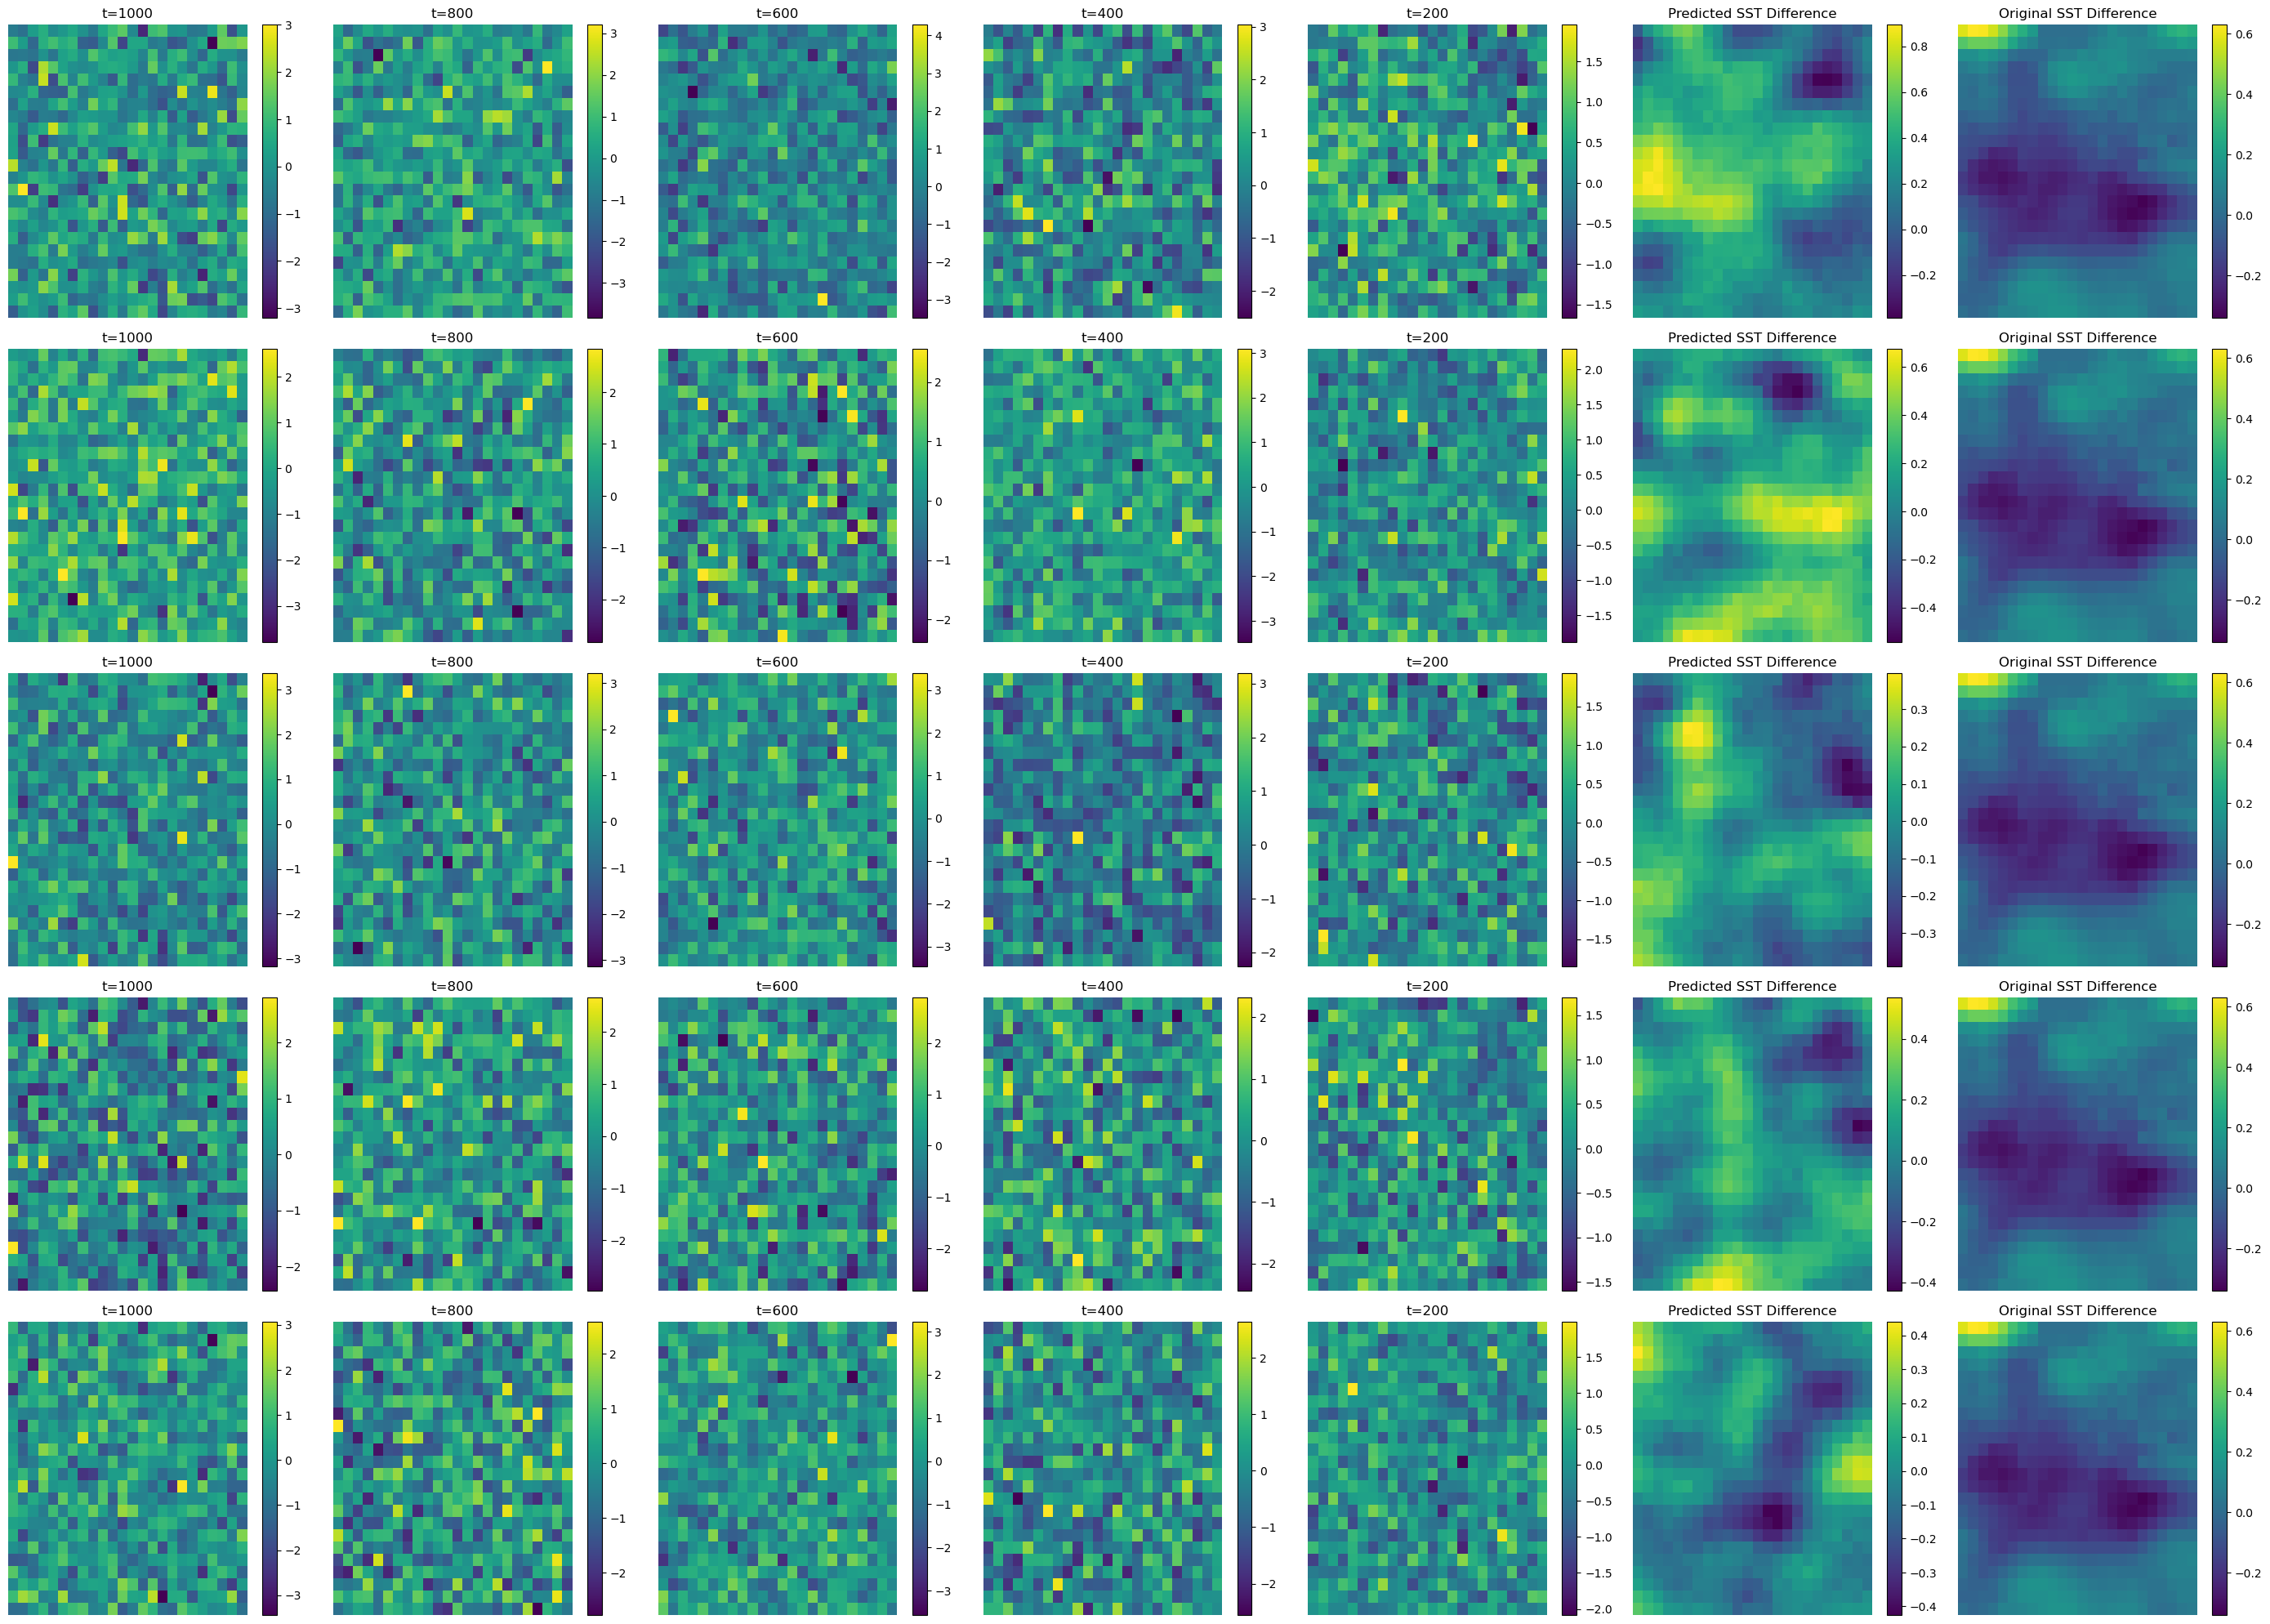

In [16]:
def generate_future_sst(backward_sampler, past_sst, original_sst, noisy_sst, times=5):
    all_recovered_ssts = []

    for _ in range(times):
        recovered_sst = noisy_sst
        recovered_ssts = []
        for i in reversed(range(forward_sampler.max_time_steps)):
            recovered_sst = backward_sampler(recovered_sst, past_sst, i)

            if i % 200 == 0:
                recovered_ssts.append(recovered_sst)

        all_recovered_ssts.append(recovered_ssts)

    nb_sst = len(all_recovered_ssts[0]) + 1
    fig, axes = plt.subplots(nrows=times, ncols=nb_sst, figsize=(4 * nb_sst, 4 * times))
    for row in range(times):
        for t, (ax, sst) in enumerate(zip(axes[row], all_recovered_ssts[row])):
            ax.set_title(f't={(nb_sst - t - 2)*200}')
            cs = ax.pcolormesh(sst[0])
            fig.colorbar(cs, ax=ax)
            ax.axis('off')
            
        axes[row, -2].set_title('Predicted SST Difference')

        ax = axes[row, -1]
        cs = ax.pcolormesh(original_sst[0])
        fig.colorbar(cs, ax=ax)
        ax.set_title('Original SST Difference')
        ax.axis('off')

    fig.tight_layout()


backward_sampler = ConditionalBackwardSampler(model, beta_scheduler, device)
past_sst, original_sst = train_ds[500]
past_sst, original_sst = torch.tensor(past_sst), torch.tensor(original_sst)
noisy_sst, _ = forward_sampler(
    original_sst, torch.tensor(forward_sampler.max_time_steps - 1))
generate_future_sst(backward_sampler, past_sst, original_sst, noisy_sst)

#### Evaluate MSE with Test Dataset

  0%|          | 0/12 [00:00<?, ?it/s]

{'diff_err': 0.8906935279568037, 'temp_err': 0.8906935478250185}

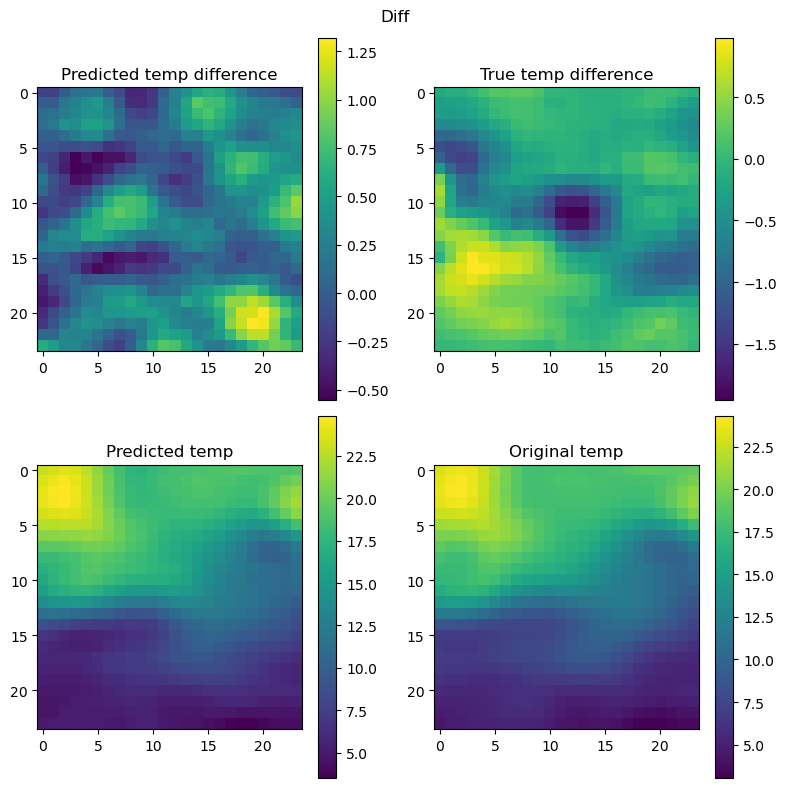

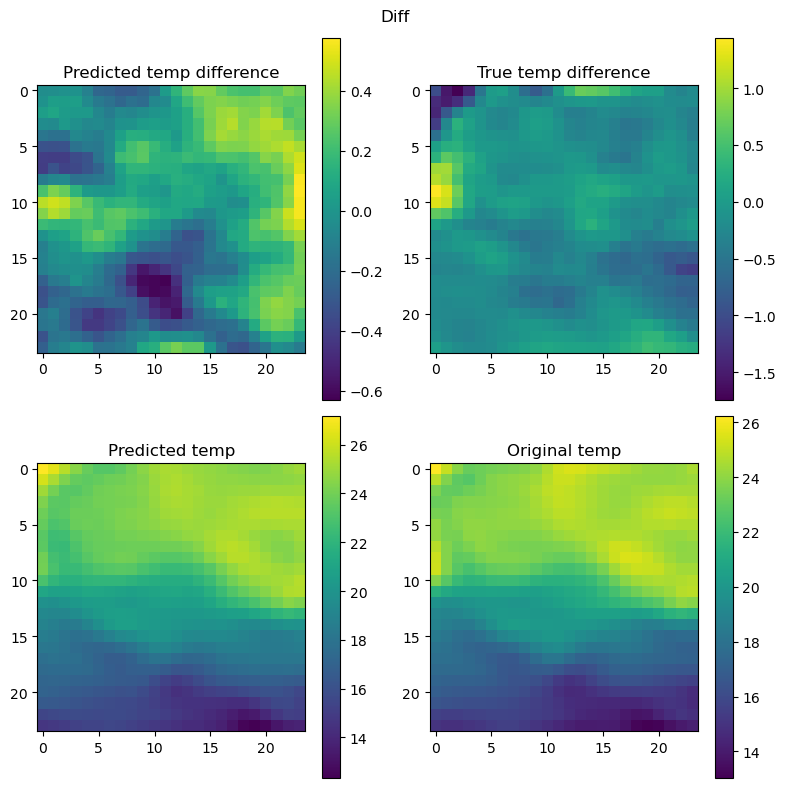

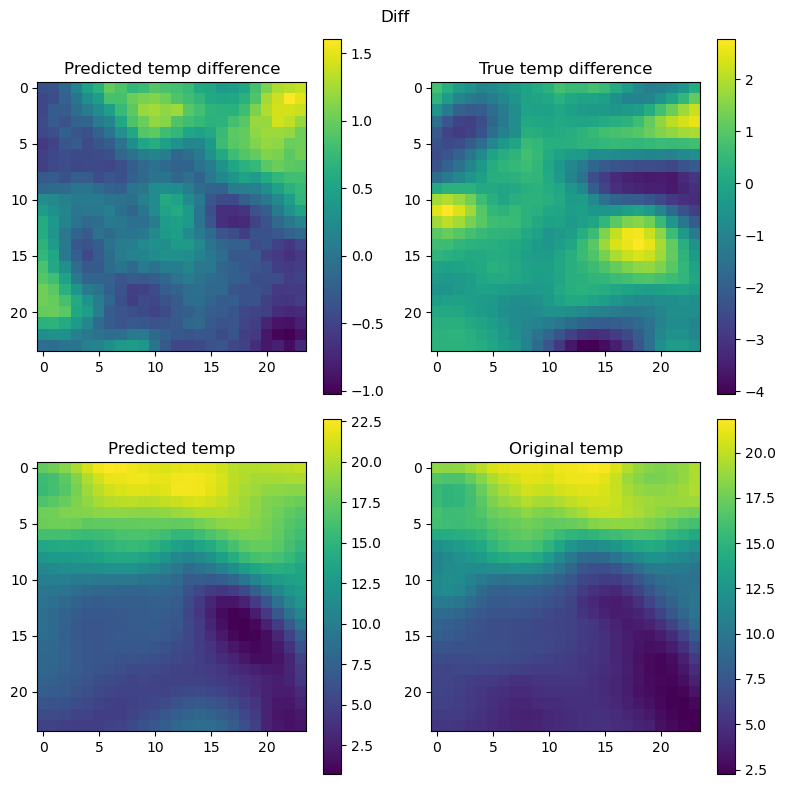

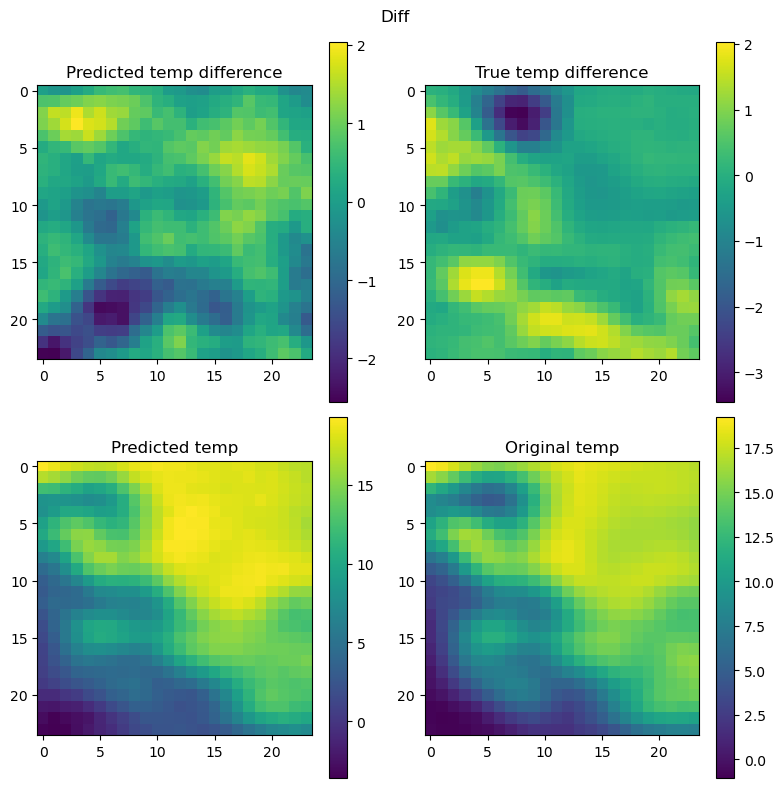

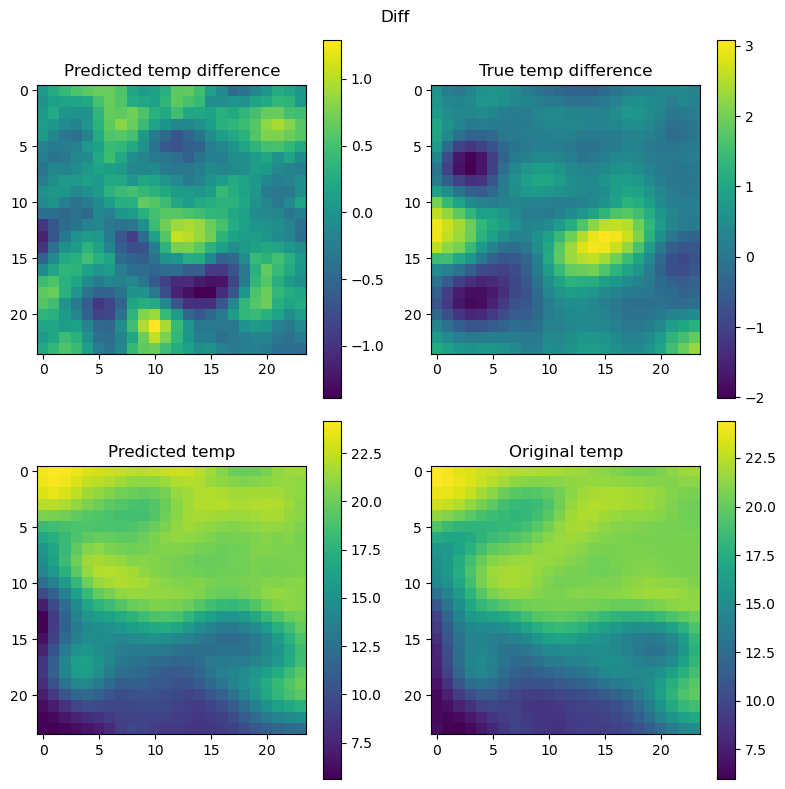

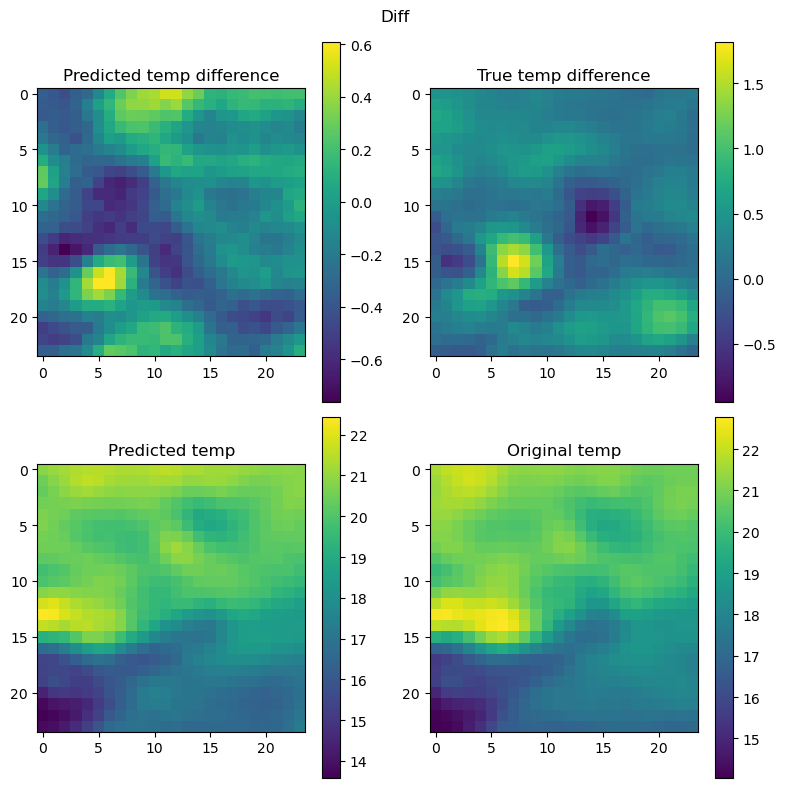

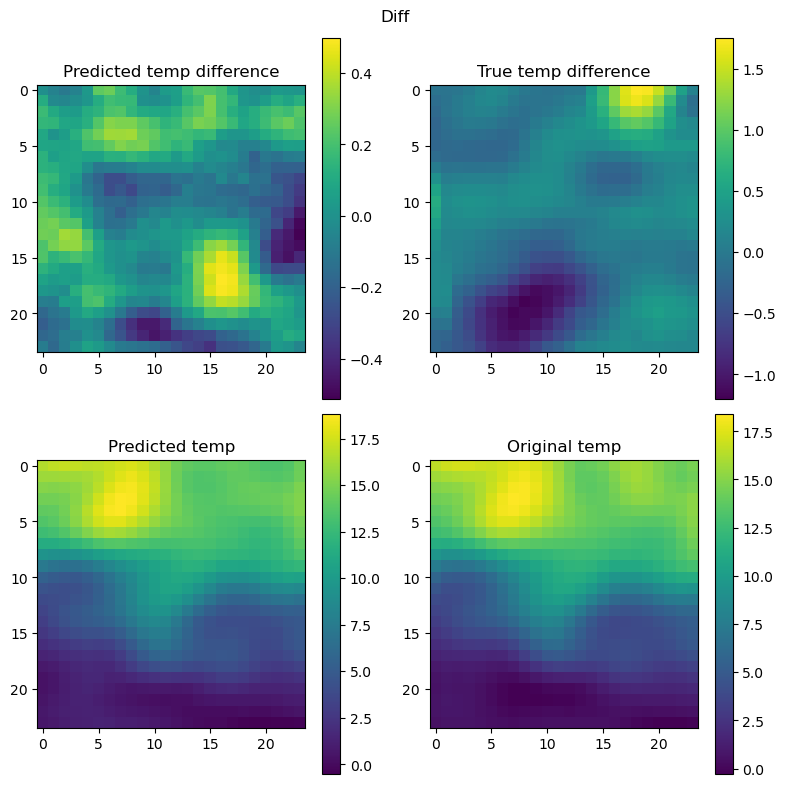

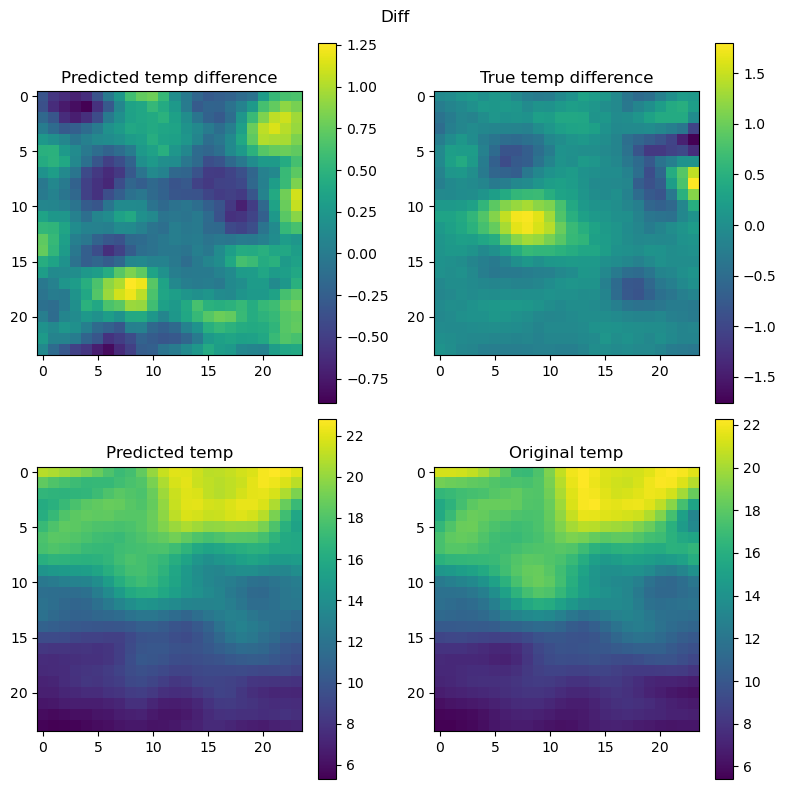

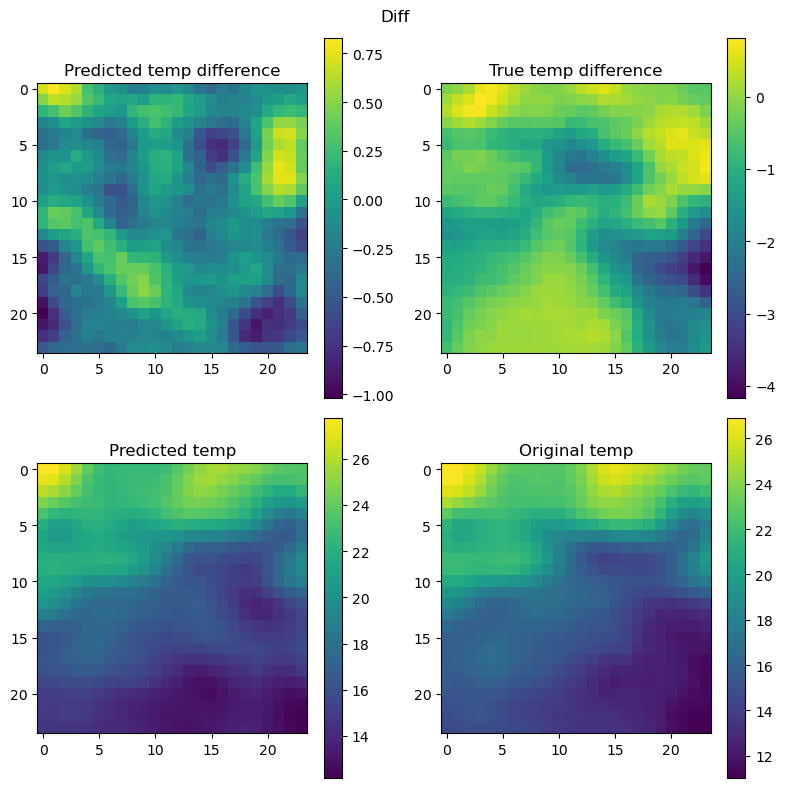

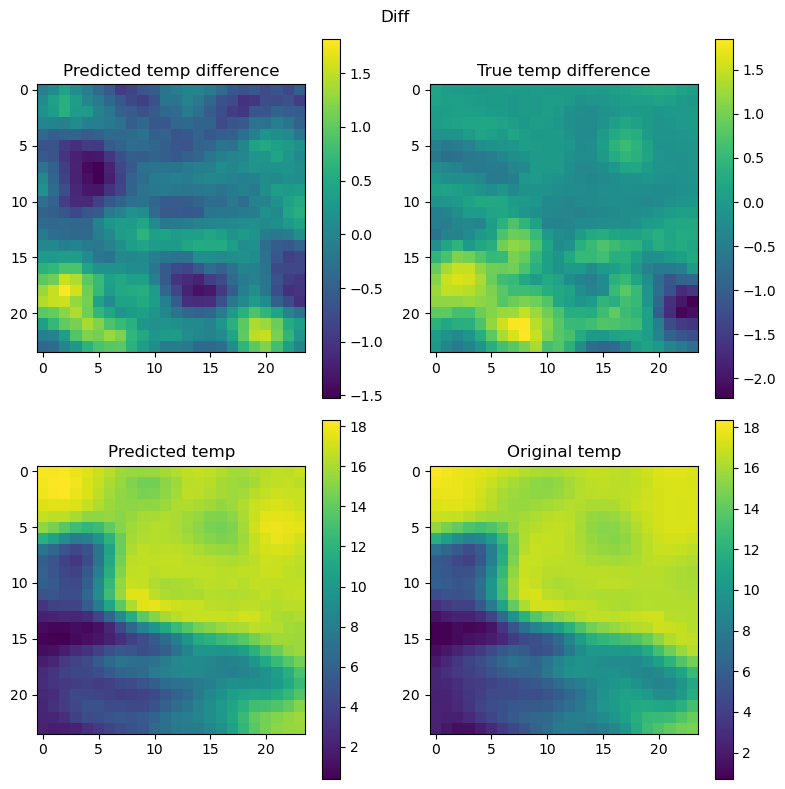

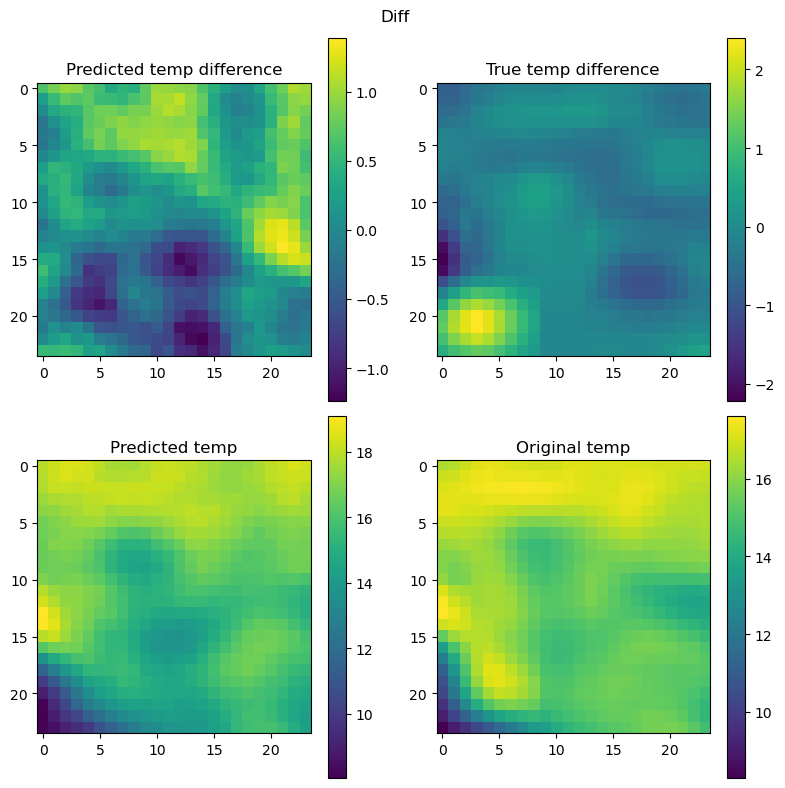

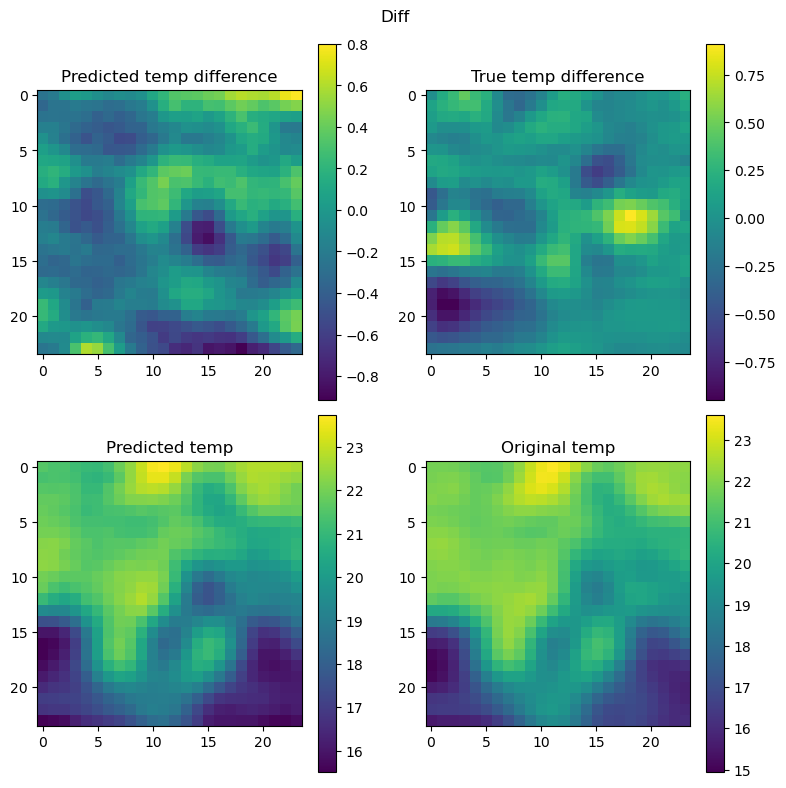

In [11]:
shown = False

@torch.no_grad()
def evaluate_mse_for_diff_ds(
        *,
        diff_dl: DataLoader,
        original_dl: DataLoader,
        backward_sampler: ConditionalBackwardSampler,
        max_time_steps: int,
        diff_temp_scaler: ScaleTemperature):
    assert len(diff_dl) == len(original_dl)

    nb_batches = len(diff_dl)
    diff_total_error = 0.
    temp_total_error = 0.

    for (X_diff, y_diff), (X, y) in tqdm(zip(diff_dl, original_dl), total=nb_batches):
        # Perform backward process.
        y_pred_diff = torch.randn_like(y_diff)

        # Feed the noisy diff sst into backward sampler to get original diff sst.
        for t in reversed(range(max_time_steps)):
            y_pred_diff = backward_sampler(y_pred_diff, X_diff, t)

        # Convert to the normal range.
        y_diff = diff_temp_scaler.inverse(y_diff)
        y_pred_diff = diff_temp_scaler.inverse(y_pred_diff.detach().cpu())

        diff_total_error += float(F.mse_loss(y_diff, y_pred_diff).item())

        # Calculate the predicted temperature.
        temp_pred = X[:, -1:] + y_pred_diff
        temp_total_error += float(F.mse_loss(y, temp_pred).item())

        # Plot results.
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
        ax = axes[0, 0]
        cs = ax.imshow(y_pred_diff[0, 0])
        ax.set_title('Predicted temp difference')
        fig.colorbar(cs, ax=ax)

        ax = axes[0, 1]
        cs = ax.imshow(y_diff[0, 0])
        ax.set_title('True temp difference')
        fig.colorbar(cs, ax=ax)

        ax = axes[1, 0]
        cs = ax.imshow(temp_pred[0, 0])
        ax.set_title('Predicted temp')
        fig.colorbar(cs, ax=ax)

        ax = axes[1, 1]
        cs = ax.imshow(y[0, 0])
        ax.set_title('Original temp')
        fig.colorbar(cs, ax=ax)
        fig.suptitle('Diff')
        fig.tight_layout()

    return dict(
        diff_err=diff_total_error / nb_batches,
        temp_err=temp_total_error / nb_batches,
    )


test_dataloader = DataLoader(test_ds, batch_size=256, num_workers=4)
test_diff_dataloader = DataLoader(test_diff_ds, batch_size=256, num_workers=4)
evaluate_mse_for_diff_ds(
    diff_dl=test_diff_dataloader,
    original_dl=test_dataloader,
    backward_sampler=backward_sampler,
    max_time_steps=forward_sampler.max_time_steps,
    diff_temp_scaler=temp_diff_scaler)